In [38]:
from yahoo_fin import stock_info as finance
import pandas as pd
import numpy as np

In [39]:
sdate = '20160101'
edate = '20231115'

In [150]:
df = finance.get_data('SPY', sdate, edate)

In [151]:
# function for calculating a rolling realized volatility 

def rolling_realized_vol(df, period = 63, shift = 0):
    # Avoid duplicate slice data
    df = df.copy()
    
    # Assuming df['close'] contains your daily close prices
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    # Define the rolling window size
    window_size = 30  # Example for a 30-day rolling window

    # Calculate rolling standard deviation of log returns
    df['rolling_std_dev'] = df['log_return'].rolling(window = period).std()

    # Annualize the standard deviation
    # Assuming 252 trading days in a year
    return (df['rolling_std_dev'] * np.sqrt(252)).shift(-shift) 

In [152]:
df['realized_vol'] = rolling_realized_vol(df)

In [153]:
df

,open,high,low,close,adjclose,volume,ticker,realized_vol
2016-01-04,200.490005,201.029999,198.589996,201.020004,175.291794,222353500,SPY,NaN
2016-01-05,201.399994,201.899994,200.050003,201.360001,175.588303,110845800,SPY,NaN
2016-01-06,198.339996,200.059998,197.600006,198.820007,173.373367,152112600,SPY,NaN
2016-01-07,195.330002,197.440002,193.589996,194.050003,169.213898,213436100,SPY,NaN
2016-01-08,195.190002,195.850006,191.580002,191.919998,167.356476,209817200,SPY,NaN
...,...,...,...,...,...,...,...,...
2023-11-08,437.549988,438.089996,434.869995,437.250000,437.250000,61746000,SPY,0.132234
2023-11-09,438.429993,438.470001,433.399994,433.839996,433.839996,83174400,SPY,0.133086
2023-11-10,435.980011,440.929993,433.829987,440.609985,440.609985,89462200,SPY,0.136351
2023-11-13,439.230011,441.329987,438.420013,440.190002,440.190002,52236100,SPY,0.134362


In [141]:
import psycopg2
import pandas as pd

class GreekAnalysis:
    def __init__(self):
        self.db_params = {
            'user': 'USER_STRING_HERE',   # Removed for Git
            'password': 'PW_STRING_HERE', # Removed for Git
            'host': 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
            'port': 5432,
            'database': 'mads'
        }

    def get_greeks_data(self, ticker, greek_type):
        with psycopg2.connect(**self.db_params) as db_connection:
            db_connection.autocommit = True
            with db_connection.cursor() as cursor:
                select_query = "SELECT * FROM greeks3 WHERE ticker=%s AND GREEK=%s"
                cursor.execute(select_query, (ticker, greek_type))
                rows = cursor.fetchall()
                df = pd.DataFrame(rows, columns=["ID", "DATE", "INCREMENT", "VALUE", "TICKER", "GREEK", "OPTION_TYPE"])
        return df

    def analyze_data(self, df, greek_type):
        merged_df = self._prepare_merged_dataframe(df, greek_type)
        merged_df[f'{greek_type}_Skew'] = merged_df[f'{greek_type}_Call'] / merged_df[f'{greek_type}_Put']
        merged_df[f'{greek_type}_Time_Spread'] = merged_df[f'{greek_type}_30'] / merged_df[f'{greek_type}_90']
        return merged_df[[f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']]

    def _prepare_merged_dataframe(self, df, greek_type):
        inc30_all = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'all')]
        inc30_call = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'call')]
        inc30_put = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'put')]
        inc90_all = df[(df['INCREMENT'] == 90) & (df['OPTION_TYPE'] == 'all')]

        merged_df = pd.DataFrame(index=inc30_all['DATE'].unique())
        merged_df[f'{greek_type}_30'] = inc30_all.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Call'] = inc30_call.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Put'] = inc30_put.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_90'] = inc90_all.groupby('DATE')['VALUE'].mean()

        return merged_df

    def _add_rolling_features(self, df, greek_type):
        periods = [1, 5, 10, 21, 42]
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            for period in periods:
                df[f'{col}_rolling_{period}'] = df[col].rolling(window=period).mean()
        return df

    def _add_z_score_features(self, df, greek_type):
        rolling_window = 90
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            df[f'{col}_z_score'] = (df[col] - df[col].rolling(window=rolling_window).mean()) / df[col].rolling(window=rolling_window).std()
        return df

    def get_analysis_for_ticker(self, ticker, greek_type='iv', include_rolling=False, include_z_score=False):
        df = self.get_greeks_data(ticker, greek_type)
        analysis_df = self.analyze_data(df, greek_type)
        if include_rolling:
            analysis_df = self._add_rolling_features(analysis_df, greek_type)
        if include_z_score:
            analysis_df = self._add_z_score_features(analysis_df, greek_type)
        return analysis_df.sort_index()

# Example usage:
greeks = GreekAnalysis()
# df_gme_iv = analysis.get_analysis_for_ticker('GME', 'iv', include_rolling = False, include_z_score = True)
# df_gme_gamma = analysis.get_analysis_for_ticker('GME', 'gamma', include_rolling = False, include_z_score = True)


In [142]:
df_iv = greeks.get_analysis_for_ticker('SPY', 'iv')

In [143]:
df = df.join(df_iv['iv_30'])

<AxesSubplot:>

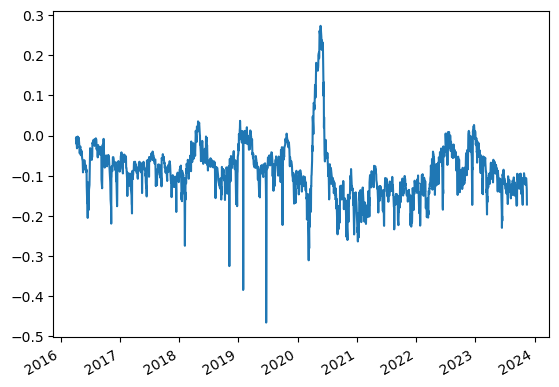

In [144]:
(df['realized_vol'] - df['iv_30']).plot()

In [145]:
df['realized_vol_shift'] = df['realized_vol'].shift(-21)

<AxesSubplot:>

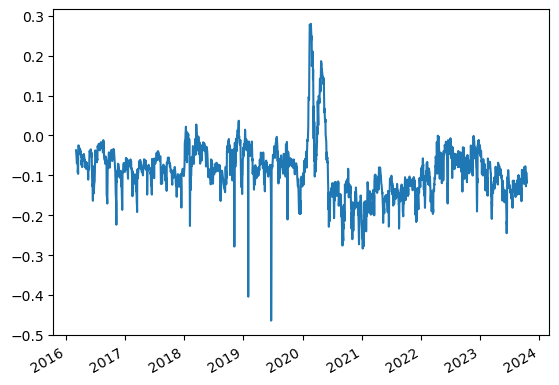

In [146]:
(df['realized_vol_shift'] - df['iv_30']).plot()

In [177]:
def rolling_z(series, period = 21):
    return (series - series.rolling(window = period).mean()) / series.rolling(window = period).std()
    

In [178]:
def comparison(ticker = 'GME', sdate = '20160101', edate = '20231115', shift = 21):
    ticker = ticker.upper()
    
    # Get data
    df = finance.get_data(ticker, sdate, edate)
    
    # Calc RV
    df['realized_vol'] = rolling_realized_vol(df, shift = shift)
    
    # Fetch IV
    df['iv_30'] = greeks.get_analysis_for_ticker(ticker, 'iv')['iv_30']
    
    # Difference 
    df['realized_iv_diff'] = df['realized_vol'] - df['iv_30']
    
    # Z score
    df['diff_z_score'] = rolling_z(df['realized_iv_diff'], period = 63)
    
    return df.dropna()

In [186]:
res = comparison('CCRN')

<AxesSubplot:>

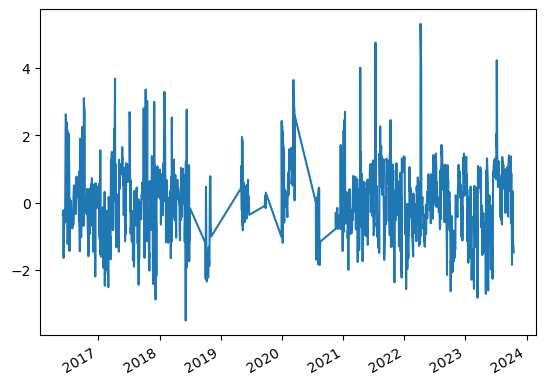

In [187]:
res['diff_z_score'].plot()